### Setup

#simulates the past
#time section to calibrate (train) the models aimming the errors evaluation
#Verify which the patterns in 2 years to see what the behavior each serie (product)
evaluation_initial_month_calibration = (2021,3) #start
evaluation_final_month_calibration = (2023,2) #end

#simulates the future - see Action and Forecast Worksheet
#time section to calculate the errors of the models trainned before.
evaluation_initial_month_validation = (2023,3)
evaluation_final_month_validation = (2023,3)


#time section to calibrate (train) the models aimming the forecast
#Verify which the patterns in 2 years to see what the behavior each serie (product)
forecast_initial_month_calibration = (2021,4)
forecast_final_month_calibration = (2023,3)

#to do Forecast - see Forecast_All_Models Worksheet
forecast_initial_month_validation = (2023,4)
forecast_final_month_validation = (2025,3)

#Considering short memory in last "move_average" months:
move_average=3

In [82]:

# evaluation_initial_month_calibration = (2021,2) #start
# evaluation_final_month_calibration = (2023,1) #end
# evaluation_initial_month_validation = (2023,2)
# evaluation_final_month_validation = (2023,2)
# forecast_initial_month_calibration = (2021,3)
# forecast_final_month_calibration = (2023,2)
# forecast_initial_month_validation = (2023,3)
# forecast_final_month_validation = (2025,2)
# move_average=3

#simulates the past
#time section to calibrate (train) the models aimming the errors evaluation
#Verify which the patterns in 2 years to see what the behavior each serie (product)
evaluation_initial_month_calibration = (2022,12) #start
evaluation_final_month_calibration = (2024,7) #end

#simulates the future - see Action and Forecast Worksheet
#time section to calculate the errors of the models trainned before.
evaluation_initial_month_validation = (2024,8)
evaluation_final_month_validation = (2024,8)


#time section to calibrate (train) the models aimming the forecast
#Verify which the patterns in 2 years to see what the behavior each serie (product)
forecast_initial_month_calibration = (2023,1)
forecast_final_month_calibration = (2024,8)

#to do Forecast - see Forecast_All_Models Worksheet
forecast_initial_month_validation = (2024,9)
forecast_final_month_validation = (2026,8)

#Variables
Date='Date'
Key=['Centro', 'TG', 'FormatoNew']
values='Peso Total'

#Considering short memory in last "move_average" months:
move_average=3
periods=20#23
seasonal_periods=2 #11

debug=False

#### Importação de Biliotecas

In [83]:
import pandas as pd
import numpy as np
import asyncio
import datetime as dt
import scipy.signal.signaltools
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import gc
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from scipy.stats import t
import warnings
warnings.filterwarnings('ignore')#warnings.filterwarnings('default')
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)
xlsx = pd.ExcelFile(r'.\Carga BG.rev.01.xlsx', engine='openpyxl')
df = pd.read_excel(xlsx,sheet_name='Carga 1')
def get_reshaped_df(df,Date,Key,values):
    df = df.set_index(Date).sort_index().reset_index()
    df['Chave'] = df[Key].astype(str).agg('_'.join, axis=1)#df['Id Produzido'].astype(str) + '_' + df['BG Produzido'].astype(str) + '_' + df['roll_width'].astype(str) + '_' + df['Centro'].astype(str)
    df['Mês'] = df[Date].dt.month
    df['Ano'] = df[Date].dt.year
    grupo = df.pivot_table(values=values, index=['Ano', 'Mês'], columns=['Chave'], aggfunc=np.sum)
    return grupo
grupo = get_reshaped_df(df=df,
                        Date=Date,
                        Key=Key,
                        values=values)
grupo

KeyboardInterrupt: 

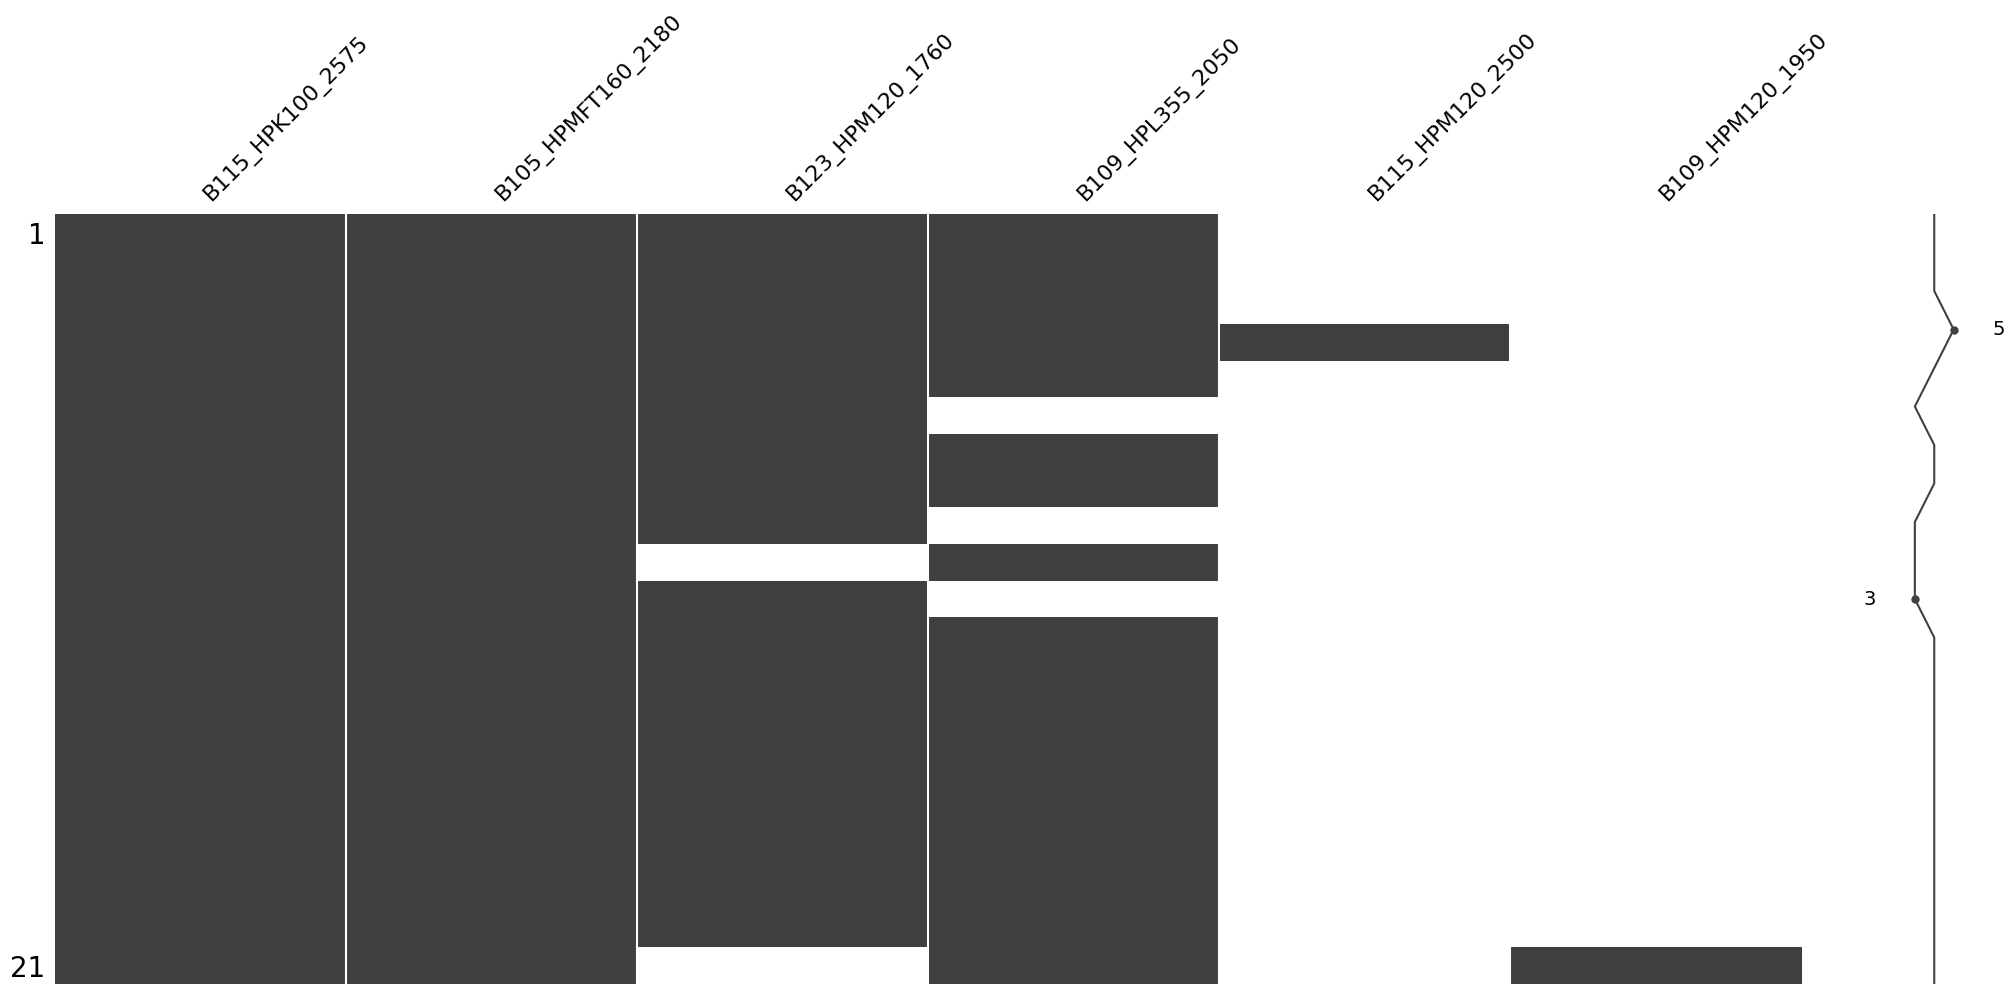

IndexError: positional indexers are out-of-bounds

In [ ]:
grupo=grupo.replace(0, np.NaN)
grupo.to_excel('.\Dados_mensais.xlsx',freeze_panes=(1,2))
sorted_data = grupo[grupo.isnull().sum().sort_values(ascending=True).index]
import missingno as msno
msno.matrix(sorted_data)
plt.show()
if debug==True:
    grupo=sorted_data.iloc[:,[0,200,300,304,-1,-10]].copy()
# grupo = grupo.iloc[:,0:1983]
colunas=grupo.columns
grupo#.loc[(2020,10):(2022,9),:]


In [ ]:
def apply_sarima(grupo,evaluation='yes'):
    treino = grupo.to_numpy().copy()
    colunas = grupo.columns.tolist()
    grupo = grupo.to_numpy()
    sarimas = []
    #sarimas=pd.DataFrame()
    for i in range(grupo.shape[1]):
        treino[:,i] = np.nan_to_num(grupo[:,i], nan=0)#.fillna(grupo.iloc[:,i].mean())#################################################################
        if np.isnan(treino[:,i]).sum() == 0:
            if evaluation=='yes':
                ###########grupo.iloc[:-1, i]

                start_year, start_month = evaluation_initial_month_calibration
                end_year, end_month = evaluation_final_month_calibration

                n_months = (end_year - start_year) * 12 + (end_month - start_month)

                #print(colunas[i])

                train_y = treino[:-1, :][:,i].copy()
        
                mask = ~np.isnan(train_y)
                train_y = train_y[mask]

                ##########yearmonth = grupo.index.to_list()[-1]
                tuples = []
                start_year=evaluation_initial_month_validation[0]
                end_year=evaluation_final_month_validation[0]
                start_month=evaluation_initial_month_validation[1]
                end_month=evaluation_final_month_validation[1]
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)


            else:
                ############train_y = grupo.iloc[:, i]
                # Define as datas de início e fim com base nas variáveis de controle
                start_date = dt.datetime(*evaluation_initial_month_calibration, 1)
                end_date = dt.datetime(*forecast_final_month_validation, 1)
                dates = pd.date_range(start=start_date, end=end_date, freq='MS')
                forecast_initial_index_calibration = dates.get_loc(dt.datetime(*forecast_initial_month_calibration, 1))
                forecast_final_index_calibration = dates.get_loc(dt.datetime(*forecast_final_month_calibration, 1))
                #forecast_initial_index_validation = dates.get_loc(datetime.datetime(*forecast_initial_month_validation, 1))
                #forecast_final_index_validation = dates.get_loc(datetime.datetime(*forecast_final_month_validation, 1))
                train_y = treino[forecast_initial_index_calibration:forecast_final_index_calibration, i].copy()

                mask = ~np.isnan(train_y)
                train_y = train_y[mask]

                ############yearmonth = grupo.index.to_list()[-1]
                ############yearmonth = ((datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).year,
                 ###########(datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).month)
                tuples = []
                start_year=forecast_initial_month_validation[0]
                end_year=forecast_final_month_validation[0]
                start_month=forecast_initial_month_validation[1]
                end_month=forecast_final_month_validation[1]
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)

            arima_model=pm.auto_arima(train_y, 
            #exogenous= train_X,
             start_p=0, start_q=0, 
             max_p=3, max_q=3, 
             #m=12,d=0,
             max_d=1,
             trace=False, 
             error_action='ignore', 
             suppress_warnings=True, 
             stepwise=True)
               
            ident = pd.MultiIndex.from_tuples(tuples,##################[yearmonth], 
                                              names=["Ano", "Mês"])
            try:
                k = arima_model.predict(n_periods=n_forecast)###################1)
                # print('agora',k,type(k))
            except ValueError:
                if evaluation == 'yes':
                    k=np.zeros(1)
                    # print('OBSERVE ESTA SÉRIE',i,'!!!!!!!!!!!!!!!!!')
                else:
                    k=np.zeros(24)
                    # print('OBSERVE ESTA SÉRIE',i,'!!!!!!!!!!!!!!!!!')
            pass
            #inte=pd.DataFrame(k,columns=[colunas[i]+"-R"],index=ident)
            #print(type(sarimas))
            #print(type(k))
            sarimas= np.concatenate((sarimas, k), axis=0)
            ultima_coluna=colunas[i]+"-R"
        else:
            sarimas[:,i]=np.nan_to_num(grupo[:,i], nan=0).mean()
            ultima_coluna=colunas[i]+"-M"
        #if sarimas.shape[0] == 1:
        if np.isnan(sarimas[i]).sum() == 0:
            sarimas[i]=np.nan_to_num(grupo[:,i], nan=0).mean()
        #else:
        #    print(sarimas)
        #    if np.isnan(sarimas[:,i]).sum() == 0:
        #        sarimas[:,i]=np.nan_to_num(grupo[:,i], nan=0).mean()
    sarimas[sarimas < 0] = 0
    return sarimas
sarimas = apply_sarima(grupo)
#sarimas.to_excel('.\Sarimas_results.xlsx')
sarimas

array([8.61247619e+01, 7.82490476e+01, 2.08676190e+01, 1.00047619e+01,
       4.04761905e-02, 2.23809524e-02])

In [ ]:
#Neste bloco é realizada a previsão dos valores para os 3 meses seguintes. A cada iteração é feito a previsão por grupo
#de produto. o Auto_Arima calcula os parâmetros ideias que melhor prevem o modelo. Depois de criado o modelo, ele pode 
#gerar a previsão dos valores futuros para quantos periodos forem necessários, nesse caso foram escolhidos 3 períodos.
#Por fim os valores previstos são exportados em uma planilha excel.

def get_tvalue(X,y):
    lm = LinearRegression()
    lm.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    #newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    #MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    '''
    p_values =[2*(1-scipy.stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
    
    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]'''
    return(np.round(ts_b[1],0))#p_values[1])
def apply_regression(grupo,evaluation='yes'):
    if evaluation=='yes':
        ###########treino = grupo.iloc[:-1,:].copy()
        treino = grupo.loc[evaluation_initial_month_calibration:evaluation_final_month_calibration,:].copy()
        ##########yearmonth = grupo.index.to_list()[-1]
        tuples = []
        start_year=evaluation_initial_month_validation[0]
        end_year=evaluation_final_month_validation[0]
        start_month=evaluation_initial_month_validation[1]
        end_month=evaluation_final_month_validation[1]
        for year in range(start_year, end_year + 1):
            start = start_month if year == start_year else 1
            end = end_month if year == end_year else 12
            for month in range(start, end + 1):
                tuples.append((year, month))
        n_forecast = len(tuples)
        initial_month = evaluation_initial_month_calibration
    else:
        #############treino = grupo.iloc[:, :].copy()
        treino = grupo.loc[forecast_initial_month_calibration:forecast_final_month_calibration,:].copy()
        ########yearmonth = ((datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).year,
         ##########(datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).month)
        tuples = []
        start_year=forecast_initial_month_validation[0]
        end_year=forecast_final_month_validation[0]
        start_month=forecast_initial_month_validation[1]
        end_month=forecast_final_month_validation[1]
        for year in range(start_year, end_year + 1):
            start = start_month if year == start_year else 1
            end = end_month if year == end_year else 12
            for month in range(start, end + 1):
                tuples.append((year, month))
        n_forecast = len(tuples)
        initial_month = forecast_initial_month_calibration
    tam=treino.shape[1]
    idx = pd.MultiIndex.from_tuples(tuples,##########[yearmonth], 
                                              names=["Ano", "Mês"])
    
    if len(str(initial_month[1]))==1:
        string_yearmonth1=str(initial_month[0])+'0'+str(initial_month[1])+'01'
    else:
        string_yearmonth1=str(initial_month[0])+str(initial_month[1])+'01'
    
    dates = pd.date_range(string_yearmonth1, periods=periods, freq='MS')
    for i in range(2,13):
        treino['Dummy'+str(i)]=np.where(dates.month==i,1,0)
    treino
    treino['Tempo']=range(1,treino.shape[0]+1)

    previsao=pd.DataFrame()

    teste=pd.DataFrame(index=idx)
    
    if len(str(initial_month[1]))==1:
        string_yearmonth2=str(initial_month[0])+'0'+str(initial_month[1])+'01'
    else:
        string_yearmonth2=str(initial_month[0])+str(initial_month[1])+'01'
    dates = pd.date_range(string_yearmonth2, periods=n_forecast,freq='MS')#############1, freq='MS')
    for i in range(2,13):
        teste['Dummy'+str(i)]=np.where(dates.month==i,1,0)
    
    teste['Tempo'] = range(treino.shape[0]+1,treino.shape[0]+1+n_forecast)#########1)
    #teste['Future_trend'] = 1
    #teste['Interaction'] = teste['Future_trend']*teste['Tempo']
    #teste['Tempo']=range(36,36+25)
    X=treino[['Tempo', 'Dummy2','Dummy3','Dummy4','Dummy5','Dummy6','Dummy7','Dummy8','Dummy9','Dummy10','Dummy11', 'Dummy12']]
    #X=treino[['Dummy2','Dummy3','Dummy4','Dummy5','Dummy6','Dummy7','Dummy8','Dummy9','Dummy10','Dummy11', 'Dummy12']]
    k=[]
    for i in range(tam):
        #treino.iloc[:,i] = treino.iloc[:,i].fillna(0.1)################################################################
        #if treino.iloc[:,i].isnull().sum() == 0:
        #X['Future_trend'] = 0
        #X['Future_trend'][-trend_months:] = 1
        #X['Interaction'] = X['Future_trend']*X['Tempo']
        regressor = LinearRegression()
        try:
            y_train = treino.iloc[:,i].fillna(0)#.fillna(treino.iloc[:,i].mean())#
            X['Last'] = y_train.shift(1).rolling(window=move_average, min_periods=1).mean().fillna(method='bfill')
            #X['Last'] = y_train.shift(1).fillna(method='bfill')
            regressor.fit(X, y_train)
        except:
            y_train = treino.iloc[:,i].fillna(0)#.fillna(treino.iloc[:,i].mean())#
            X['Last'] = y_train.shift(1).rolling(window=move_average, min_periods=1).mean().fillna(method='bfill')
            regressor.fit(X, y_train)
        k.append(regressor.coef_[0])
        #if ((abs(get_tvalue(X,y_train))==0) and ((y_train == 0).sum() == 0)):
        if ((abs(regressor.coef_[0])<0) and ((y_train == 0).sum() == 0)):# the value 100 is a trend consideration regulator
            #X.loc[:,'Tempo'] = np.log(X.loc[:,'Tempo'])
            #teste['Last'] = y_train[-1]
            regressor.fit(X, y_train)
            teste['Last'] = y_train[-move_average:].mean()
            #teste.loc[:,'Tempo'] = np.log(teste.loc[:,'Tempo'])
            y_pred = pd.DataFrame(regressor.predict(teste),columns=[colunas[i]+"-R"],index=idx)
            #X.loc[:,'Tempo'] = range(1,treino.shape[0]+1)
            #teste.loc[:,'Tempo'] = range(treino.shape[0]+1,treino.shape[0]+1+30)

            #y_train = treino.iloc[:,i].fillna(0)
            #a = (max(y_train)-min(y_train))
            #y_train_transf=((y_train-min(y_train))/a) + 0.0001
            #y_train = y_train+m+0.1
            #regressor.fit(X, np.log(y_train_transf))
            #y_pred = pd.DataFrame((np.exp(regressor.predict(teste))-0.0001)*a,columns=[colunas[i]+"-R"],index=idx)
        else:
            teste['Last'] = y_train[-3:].mean()
            regressor.fit(X.drop(['Tempo'],axis=1), y_train)
            y_pred = pd.DataFrame(regressor.predict(teste.drop(['Tempo'],axis=1)),columns=[colunas[i]+"-R"],index=idx)
            #regressor.fit(X, np.exp(y_train/100000))
            #y_pred = pd.DataFrame(np.log(regressor.predict(teste))*100000,columns=[colunas[i]+"-R"],index=idx)

            #y_train = treino.iloc[:,i].fillna(0)
            #m=abs(min(y_train))
            #y_train = y_train+m+0.1
            #regressor.fit(X, np.log(y_train))
            #y_pred = pd.DataFrame(np.exp(regressor.predict(teste))-m-0.1,columns=[colunas[i]+"-R"],index=idx)  
        previsao= pd.concat([previsao, y_pred], axis=1, join='outer')
        ultima_coluna=colunas[i]+"-R"
    '''    else:
            #previsao[colunas[i]+"_M"]=treino.iloc[:,i].fillna(0).mean()
            previsao[colunas[i]+"-M"]=pd.DataFrame((pd.concat([treino.iloc[:,i].iloc[9:21], 
                                      treino.iloc[:,i].iloc[9:21],
                                      treino.iloc[:,i].iloc[9:15]],
                                      axis=0, join='outer')).values,columns=[colunas[i]+"-M"],index=idx).fillna(0)
            ultima_coluna=colunas[i]+"-M"'''
    if previsao[ultima_coluna].fillna(0).sum() == 0:
        previsao[ultima_coluna]=treino.iloc[:,i].fillna(0).mean()
    previsao[previsao < 0] = 0
    #previsao.T.to_excel('.\Regression_Results.xlsx')
    #previsao.iloc[3:15].T.sum().sum()
    return previsao
previsao = apply_regression(grupo)
previsao

,,B115_HPK100_2575-R,B105_HPMFT160_2180-R,B123_HPM120_1760-R,B109_HPL355_2050-R,B115_HPM120_2500-R,B109_HPM120_1950-R
Ano,Mês,,,,,,
2024,8,77.586001,263.153249,45.204748,4.837519,5.551115e-17,0.0


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def apply_expsmoothing(grupo,evaluation='yes'):
    expsmoothing=pd.DataFrame()
    treino2=grupo.copy()
    for i in range(grupo.shape[1]):
        treino2.iloc[:,i] = grupo.iloc[:,i].fillna(grupo.iloc[:,i].mean())#################################################################
        if treino2.iloc[:,i].isnull().sum() == 0:
            if evaluation=='yes':
                ###########grupo.iloc[:-1, i]
                train_y2 = treino2.loc[evaluation_initial_month_calibration:evaluation_final_month_calibration,:].iloc[:,i].copy()
                train_y2=train_y2.dropna()
                ##########yearmonth = grupo.index.to_list()[-1]
                tuples = []
                start_year=evaluation_initial_month_validation[0]
                end_year=evaluation_final_month_validation[0]
                start_month=evaluation_initial_month_validation[1]
                end_month=evaluation_final_month_validation[1]
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)
            else:
                ############train_y = grupo.iloc[:, i]
                train_y2 = treino2.loc[forecast_initial_month_calibration:forecast_final_month_calibration,:].iloc[:,i].copy()
                train_y2=train_y2.dropna()
                ############yearmonth = grupo.index.to_list()[-1]
                ############yearmonth = ((datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).year,
                 ###########(datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).month)
                tuples = []
                start_year=forecast_initial_month_validation[0]
                end_year=forecast_final_month_validation[0]
                start_month=forecast_initial_month_validation[1]
                end_month=forecast_final_month_validation[1]
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)
            #print(train_y)
            model3 = ExponentialSmoothing(train_y2, trend='add', seasonal='add', damped_trend=True, seasonal_periods=seasonal_periods)
            fit3 = model3.fit()
            ident = pd.MultiIndex.from_tuples(tuples,##################[yearmonth], 
                                              names=["Ano", "Mês"])
            try:
                k3 = fit3.predict(start=0, end=23+n_forecast)###################1)
                if evaluation=='yes':
                    prediction=k3.iloc[-1]
                else:
                    prediction=k3.iloc[-24:]
            except ValueError:
                k3=0
                print('OBSERVE ESTA SÉRIE !!!!!!!!!!!!!!!!!')
                pass
            if evaluation=='yes':
                inte_=pd.DataFrame({colunas[i]+"-R": prediction},index=ident)
            else:
                inte_=pd.DataFrame({colunas[i]+"-R": prediction.to_list()},index=ident)
            expsmoothing= pd.concat([expsmoothing, inte_], axis=1, join='outer')
            
            ultima_coluna=colunas[i]+"-R"
        else:
            expsmoothing[colunas[i]+"-M"]=grupo.iloc[:,i].fillna(0).mean()
            ultima_coluna=colunas[i]+"-M"
        #if expsmoothing[ultima_coluna].fillna(0).sum() == 0:
        #    expsmoothing[ultima_coluna]=grupo.iloc[:,i].fillna(0).mean()
    expsmoothing[expsmoothing < 0] = 0
    
    return expsmoothing
expsmoothing = apply_expsmoothing(grupo)
expsmoothing

,,B115_HPK100_2575-R,B105_HPMFT160_2180-R,B123_HPM120_1760-R,B109_HPL355_2050-R,B115_HPM120_2500-R,B109_HPM120_1950-R
Ano,Mês,,,,,,
2024,8,95.505363,298.702707,18.749396,13.07373,0.85,0.47


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def apply_seasonaldecompose(grupo, evaluation='yes'):
    decompose = pd.DataFrame()
    treino = grupo.copy()
    for i in range(grupo.shape[1]):
        treino.iloc[:,i] = grupo.iloc[:,i].fillna(grupo.iloc[:,i].mean())
        if treino.iloc[:,i].isnull().sum() == 0:
            if evaluation=='yes':
                train_y = treino.iloc[:,i].copy()
                tuples = [(evaluation_initial_month_validation[0], evaluation_initial_month_validation[1])]
                n_forecast = len(tuples)
                index = pd.date_range(start=datetime(*(evaluation_initial_month_calibration+(1,))).date()
                                  , periods=train_y.shape[0], freq='MS')
            else:
                train_y = treino.iloc[:,i].copy()
                start_year = forecast_initial_month_validation[0]
                end_year = forecast_final_month_validation[0]
                start_month = forecast_initial_month_validation[1]
                end_month = forecast_final_month_validation[1]
                tuples = []
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)
                index = pd.date_range(start=datetime(*(forecast_initial_month_calibration+(1,))).date()
                                  , periods=train_y.shape[0], freq='MS')
            try:
                result = seasonal_decompose(pd.DataFrame(train_y.values,index=index), model='add')
                seasonal = result.seasonal.fillna(method='ffill')
                trend = result.trend.fillna(method='ffill')
                residual = result.resid.fillna(method='ffill')
                forecasted_values = []
                for n in range(n_forecast): 
                    k = trend[-1] + seasonal[(seasonal.index[-1].month + n - 1) % 12] + np.sum(residual[-12:]) / 12 
                    forecasted_values.append(k)
                ident = pd.MultiIndex.from_tuples(tuples, names=["Ano", "Mês"])
                inte=pd.DataFrame(forecasted_values,columns=[treino.columns[i]+"-R"], index=ident)
                decompose = pd.concat([decompose, inte], axis=1, join='outer')
            except ValueError as ve:
                print(f'Error with column {i}: {ve}')
    decompose[decompose < 0] = 0
    return decompose

decompose = apply_seasonaldecompose(grupo)
decompose

Error with column 0: x must have 2 complete cycles requires 24 observations. x only has 21 observation(s)
Error with column 1: x must have 2 complete cycles requires 24 observations. x only has 21 observation(s)
Error with column 2: x must have 2 complete cycles requires 24 observations. x only has 21 observation(s)
Error with column 3: x must have 2 complete cycles requires 24 observations. x only has 21 observation(s)
Error with column 4: x must have 2 complete cycles requires 24 observations. x only has 21 observation(s)
Error with column 5: x must have 2 complete cycles requires 24 observations. x only has 21 observation(s)


""


In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# def apply_seasonaldecompose(grupo,evaluation='yes'):
#     decompose=pd.DataFrame()
#     treino=grupo.copy()
#     for i in range(grupo.shape[1]):
#         treino.iloc[:,i] = grupo.iloc[:,i].fillna(grupo.iloc[:,i].mean())#################################################################
#         if treino.iloc[:,i].isnull().sum() == 0:
#             if evaluation=='yes':
#                 ###########grupo.iloc[:-1, i]
#                 train_y = treino.loc[evaluation_initial_month_calibration:evaluation_final_month_calibration,:].iloc[:,i].copy()
#                 train_y=train_y.dropna()
#                 ##########yearmonth = grupo.index.to_list()[-1]
#                 tuples = []
#                 start_year=evaluation_initial_month_validation[0]
#                 end_year=evaluation_final_month_validation[0]
#                 start_month=evaluation_initial_month_validation[1]
#                 end_month=evaluation_final_month_validation[1]
#                 for year in range(start_year, end_year + 1):
#                     start = start_month if year == start_year else 1
#                     end = end_month if year == end_year else 12
#                     for month in range(start, end + 1):
#                         tuples.append((year, month))
#                 n_forecast = len(tuples)
#                 index = pd.date_range(start=datetime(*(evaluation_initial_month_calibration+(1,))).date()
#                                   , end=datetime(*(evaluation_final_month_calibration+(1,))).date(), freq='MS')

#             else:
#                 ############train_y = grupo.iloc[:, i]
#                 train_y = treino.loc[forecast_initial_month_calibration:forecast_final_month_calibration,:].iloc[:,i].copy()
#                 train_y=train_y.dropna()
#                 ############yearmonth = grupo.index.to_list()[-1]
#                 ############yearmonth = ((datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).year,
#                  ###########(datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).month)
#                 tuples = []
#                 start_year=forecast_initial_month_validation[0]
#                 end_year=forecast_final_month_validation[0]
#                 start_month=forecast_initial_month_validation[1]
#                 end_month=forecast_final_month_validation[1]
#                 for year in range(start_year, end_year + 1):
#                     start = start_month if year == start_year else 1
#                     end = end_month if year == end_year else 12
#                     for month in range(start, end + 1):
#                         tuples.append((year, month))
#                 n_forecast = len(tuples)
            
#                 index = pd.date_range(start=datetime(*(evaluation_initial_month_calibration+(1,))).date()
#                                   , end=datetime(*(evaluation_final_month_calibration+(1,))).date(), freq='MS')
#             #print(pd.DataFrame(train_y.values,index=index))
#             result = seasonal_decompose(pd.DataFrame(train_y.values,index=index), model='add')
#             ident = pd.MultiIndex.from_tuples(tuples,##################[yearmonth], 
#                                               names=["Ano", "Mês"])
#             try:
#                 seasonal = result.seasonal
#                 trend = result.trend
#                 residual = result.resid
#                 n_periods = 1
#                 trend.fillna(trend.mean(),inplace=True)
#                 residual.fillna(residual.mean(),inplace=True)
#                 k = trend[-1] + seasonal[-1] + np.sum(residual[-12:]) / 12 # forecast for the next period
#             except ValueError:
#                 k=0
#                 print('OBSERVE ESTA SÉRIE !!!!!!!!!!!!!!!!!')
#                 pass
#             if evaluation=='yes':
#                 inte3=pd.DataFrame({colunas[i]+"-R": prediction2},index=ident)
#             else:
#                 inte3=pd.DataFrame({colunas[i]+"-R": prediction2.to_list()},index=ident)
#             #inte3=pd.DataFrame(k,columns=[colunas[i]+"-R"],index=ident)
#             decompose= pd.concat([decompose, inte3], axis=1, join='outer')
#             ultima_coluna=colunas[i]+"-R"
#         else:
#             decompose[colunas[i]+"-M"]=grupo.iloc[:,i].fillna(0).mean()
#             ultima_coluna=colunas[i]+"-M"
#         if decompose[ultima_coluna].fillna(0).sum() == 0:
#             decompose[ultima_coluna]=grupo.iloc[:,i].fillna(0).mean()
#     decompose[decompose < 0] = 0
#     return decompose
# #decompose = apply_seasonaldecompose(grupo)
# decompose = apply_seasonaldecompose(grupo)
# decompose

In [ ]:
sarimas=pd.DataFrame([sarimas],columns=grupo.columns,#.to_list(),
                     index=pd.MultiIndex.from_tuples([evaluation_initial_month_validation], names=['Ano', 'Mês']))
df_melted = pd.melt(grupo, value_vars=grupo.columns,ignore_index=False).reset_index().fillna(0)
previsao = pd.melt(previsao, value_vars=previsao.columns,ignore_index=False)
previsao['Chave'] = previsao['variable'].str[:-2]
previsao.reset_index(inplace=True)
previsao2=previsao.merge(df_melted, left_on=['Ano','Mês','Chave'],
                        right_on=['Ano','Mês','Chave'],
                        how='left')
previsao2.drop(['Chave'],axis=1,inplace=True)
previsao2 = previsao2.rename(columns={'value_x': 'Forecast', 'value_y': 'Actual'})
previsao2.loc[:,'MAD'] = abs(previsao2.loc[:,'Forecast']-previsao2.loc[:,'Actual'])
previsao2 = previsao2.set_index(['Ano','Mês'])
k=df_melted.loc[~((df_melted['Ano']==grupo.index.to_list()[-1][0]) & (df_melted['Mês']>=grupo.index.to_list()[-1][1]))]
k=k.groupby('Chave').value.agg(['mean']).reset_index()
previsao2['Chave'] = previsao2['variable'].str[:-2]
previsao3=previsao2.reset_index().merge(k, left_on=['Chave'],
                        right_on=['Chave'],
                        how='left')
previsao3.loc[:,'MAD_mean'] = abs(previsao3.loc[:,'mean']-previsao3.loc[:,'Actual'])
sarimas = pd.melt(sarimas, value_vars=sarimas.columns,ignore_index=False)


#sarimas['Chave'] = sarimas['variable'].str[:-2]
sarimas.reset_index(inplace=True)
sarimas.rename(columns={'value': 'Forecast_Sarima'},inplace=True)#,'Chave': 'variable_Sarima'},inplace=True)
previsao4 = previsao3.merge(sarimas, left_on=['Ano','Mês','Chave'],
                        right_on=['Ano','Mês','Chave'],
                        how='left')
previsao4.loc[:,'MAD_Sarima'] = abs(previsao4.loc[:,'Forecast_Sarima']-previsao4.loc[:,'Actual'])
expsmoothing = pd.melt(expsmoothing, value_vars=expsmoothing.columns,ignore_index=False)
expsmoothing['Chave'] = expsmoothing['variable'].str[:-2]
expsmoothing.reset_index(inplace=True)
expsmoothing.rename(columns={'value': 'Forecast_ExpSmooth','variable': 'variable_ExpSmooth'},inplace=True)
previsao5 = previsao4.merge(expsmoothing, left_on=['Ano','Mês','Chave'],
                        right_on=['Ano','Mês','Chave'],
                        how='left')
previsao5.loc[:,'MAD_ExpSmooth'] = abs(previsao5.loc[:,'Forecast_ExpSmooth']-previsao5.loc[:,'Actual'])
# decompose = pd.melt(decompose, value_vars=decompose.columns,ignore_index=False)
# decompose['Chave'] = decompose['variable'].str[:-2]
# decompose.reset_index(inplace=True)
# decompose.rename(columns={'value': 'Forecast_Decompose','variable': 'variable_Decompose'},inplace=True)
# previsao6 = previsao5.merge(decompose, left_on=['Ano','Mês','Chave'],
#                         right_on=['Ano','Mês','Chave'],
#                         how='left')
# previsao6.loc[:,'MAD_Decompose'] = abs(previsao6.loc[:,'Forecast_Decompose']-previsao6.loc[:,'Actual'])
somas=previsao5.loc[:,['Chave','MAD','MAD_mean','MAD_Sarima','MAD_ExpSmooth']].groupby('Chave').agg(['sum']).reset_index()
somas['Menor']=somas.iloc[:,1:5].idxmin(axis=1)
somas=somas.sort_values('Chave')
previsao6=previsao5.sort_values('Chave')
condicoes = [somas['Menor'] == ('MAD', 'sum'),
    somas['Menor'] == ('MAD_mean', 'sum'),
    somas['Menor'] == ('MAD_Sarima', 'sum'),
    somas['Menor'] == ('MAD_ExpSmooth', 'sum')]
    # somas['Menor'] == ('MAD_Decompose', 'sum')]
valores = [previsao5['Forecast'], previsao5['mean'], previsao5['Forecast_Sarima'],previsao5['Forecast_ExpSmooth']]
previsao5['Forecast_Mixed']= np.select(condicoes, valores)
previsao5.loc[:,'MAD_Mixed'] = abs(previsao5.loc[:,'Forecast_Mixed']-previsao5.loc[:,'Actual'])
forecast_mixed=previsao5.pivot_table(values='Forecast_Mixed', index=['Chave'],
                     columns=['Ano','Mês'],
                     aggfunc=sum,margins=False)

previsao5['variable'] = previsao5['variable'].map(lambda x: x[:-2])
previsao5[Key] = previsao5['variable'].str.split('_', expand=True)
previsao5.drop(['variable','variable_ExpSmooth'],axis=1,inplace=True)
previsao5=previsao5[k.columns.tolist()[:2]+previsao5.columns.tolist()[-3:]+previsao5.columns.tolist()[2:-3]]
previsao5['melhor'] = somas['Menor']
previsao5.to_excel('ActualAndForecast_forecaster.xlsx',index=False)
previsao5

KeyError: "['variable_Decompose'] not found in axis"

In [ ]:
sarimas

,Ano,Mês,Chave,Forecast_Sarima
0,2024,8,B115_HPK100_2575,86.124762
1,2024,8,B105_HPMFT160_2180,78.249048
2,2024,8,B123_HPM120_1760,20.867619
3,2024,8,B109_HPL355_2050,10.004762
4,2024,8,B115_HPM120_2500,0.040476
5,2024,8,B109_HPM120_1950,0.022381


In [ ]:
print('Regression WAPE = ',np.round((previsao5.MAD.sum()/previsao5.Actual.sum())*100,0),'%',sep='')
print('Mean WAPE = ',np.round((previsao5.MAD_mean.sum()/previsao5.Actual.sum())*100,0),'%',sep='')
print('Sarima WAPE = ',np.round((previsao5.MAD_Sarima.sum()/previsao5.Actual.sum())*100,0),'%',sep='')
print('ExpSmoothing WAPE = ',np.round((previsao5.MAD_ExpSmooth.sum()/previsao5.Actual.sum())*100,0),'%',sep='')
# print('Decompose WAPE = ',np.round((previsao5.MAD_Decompose.sum()/previsao5.Actual.sum())*100,0),'%',sep='')
print('Mixed WAPE = ',np.round((previsao5.MAD_Mixed.sum()/previsao5.Actual.sum())*100,0),'%',sep='')

Regression WAPE = 232.0%
Mean WAPE = 78.0%
Sarima WAPE = 74.0%
ExpSmoothing WAPE = 247.0%
Mixed WAPE = 246.0%


In [ ]:
sarimas = apply_sarima(grupo,evaluation='no')
expsmoothing = apply_expsmoothing(grupo,evaluation='no')
# decompose = apply_seasonaldecompose(grupo,evaluation='no')
previsao = apply_regression(grupo,evaluation='no')
df_melted = pd.melt(grupo, value_vars=grupo.columns,ignore_index=False).reset_index()
k=df_melted.loc[~((df_melted['Ano']==grupo.index.to_list()[-1][0]) & (df_melted['Mês']>=grupo.index.to_list()[-1][1]))]#.fillna(0)
k=k.groupby('Chave').value.agg(['mean']).reset_index()
# Função para renomear colunas
def rename_columns(row, columns):
    new_columns = {}
    for i, column in enumerate(columns):
        new_columns[column] = row[i]
    return new_columns

# Renomear colunas
k = k.T.rename(columns=rename_columns(k.T.iloc[0], k.T.columns)).iloc[1:,:]
k=k.T

dates = pd.date_range(start=f"{forecast_initial_month_validation[0]}-{forecast_initial_month_validation[1]}", 
                      end=f"{forecast_final_month_validation[0]}-{forecast_final_month_validation[1]}", 
                      freq='MS')
sarimas = pd.DataFrame(sarimas.reshape(-1, len(dates)), columns=[f"Sarima_({date.year}, {date.month})" for date in dates])
sarimas.index=grupo.columns.to_list()
k=k.merge(sarimas,left_index=True, right_index=True, how='outer')

previsao=previsao.T
previsao.index = previsao.index.map(lambda x: x[:-2])
previsao.columns = previsao.columns.map(lambda x: 'Regression_{}'.format(x))
k=k.merge(previsao,left_index=True, right_index=True, how='outer')

expsmoothing=expsmoothing.T
expsmoothing.index = expsmoothing.index.map(lambda x: x[:-2])
expsmoothing.columns = expsmoothing.columns.map(lambda x: 'ExpSmoothing_{}'.format(x))
k=k.merge(expsmoothing,left_index=True, right_index=True, how='outer')

# decompose=decompose.T
# decompose.index = decompose.index.map(lambda x: x[:-2])
# decompose.columns = decompose.columns.map(lambda x: 'Decompose_{}'.format(x))
# k=k.merge(decompose,left_index=True, right_index=True, how='outer')

In [ ]:
sarimas


,"Sarima_(2024, 9)","Sarima_(2024, 10)","Sarima_(2024, 11)","Sarima_(2024, 12)","Sarima_(2025, 1)","Sarima_(2025, 2)","Sarima_(2025, 3)","Sarima_(2025, 4)","Sarima_(2025, 5)","Sarima_(2025, 6)",...,"Sarima_(2025, 11)","Sarima_(2025, 12)","Sarima_(2026, 1)","Sarima_(2026, 2)","Sarima_(2026, 3)","Sarima_(2026, 4)","Sarima_(2026, 5)","Sarima_(2026, 6)","Sarima_(2026, 7)","Sarima_(2026, 8)"
B115_HPK100_2575,86.124762,78.249048,20.867619,10.004762,0.040476,0.022381,91.163158,91.163158,91.163158,91.163158,...,91.163158,91.163158,91.163158,91.163158,91.163158,91.163158,91.163158,91.163158,91.163158,91.163158
B105_HPMFT160_2180,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,...,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000
B123_HPM120_1760,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,...,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000
B109_HPL355_2050,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,...,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579
B115_HPM120_2500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B109_HPM120_1950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
backup = k

In [ ]:
k = backup

In [ ]:
k = backup
k=k.reset_index()
#k['Melhor'] = somas["Menor"]
k[Key] = k['index'].str.split('_', expand=True)
k.drop(['index'],axis=1,inplace=True)
k=k[k.columns.tolist()[-3:]+k.columns.tolist()[:-3]]
k
tuples = []
start_year=forecast_initial_month_validation[0]
end_year=forecast_final_month_validation[0]
start_month=forecast_initial_month_validation[1]
end_month=forecast_final_month_validation[1]
for year in range(start_year, end_year + 1):
    start = start_month if year == start_year else 1
    end = end_month if year == end_year else 12
    for month in range(start, end + 1):
        tuples.append((year, month))
n_forecast = len(tuples)
k['Best_model']=somas['Menor'].apply(lambda x: x[0]) 
condicoes = [k['Best_model'] == 'MAD',
    k['Best_model'] == 'MAD_mean',
    k['Best_model'] == 'MAD_Sarima',
    k['Best_model'] == 'MAD_ExpSmooth']
    # k['Best_model'] == 'MAD_Decompose']
valores = ['Regression','Mean','Sarima','ExpSmooth']#,'Decompose']
k['Best_model']= np.select(condicoes, valores)
for i in range(n_forecast):
    condicoes = [k['Best_model'] == 'Regression',
    k['Best_model'] == 'Mean',
    k['Best_model'] == 'Sarima',
    k['Best_model'] == 'ExpSmooth']
    # k['Best_model'] == 'Decompose']
    valores=[k['Regression_'+str(tuples[i])],k['mean'],
                                       k['Sarima_'+str(tuples[i])],k['ExpSmoothing_'+str(tuples[i])]]#,
                                    #    k['Decompose_'+str(tuples[i])]]
    k.loc[:,'Mixed_'+str(tuples[i])] = np.select(condicoes, valores)
k[Key + ['Best_model'] + k.columns[k.columns.str.startswith('Mixed_')].to_list()].to_excel('forecast_all_models_forecaster.xlsx',index=False)
k

,Centro,TG,FormatoNew,mean,"Sarima_(2024, 9)","Sarima_(2024, 10)","Sarima_(2024, 11)","Sarima_(2024, 12)","Sarima_(2025, 1)","Sarima_(2025, 2)",...,"Mixed_(2025, 11)","Mixed_(2025, 12)","Mixed_(2026, 1)","Mixed_(2026, 2)","Mixed_(2026, 3)","Mixed_(2026, 4)","Mixed_(2026, 5)","Mixed_(2026, 6)","Mixed_(2026, 7)","Mixed_(2026, 8)"
0,B105,HPMFT160,2180,77.972,245.530000,245.530000,245.530000,245.530000,245.530000,245.530000,...,245.53,245.53,245.53,245.53,245.53,245.53,245.53,245.53,245.53,245.53
1,B109,HPL355,2050,11.553529,10.061579,10.061579,10.061579,10.061579,10.061579,10.061579,...,13.317849,13.147748,13.318224,13.148048,13.318464,13.14824,13.318618,13.148363,13.318716,13.148442
2,B109,HPM120,1950,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47
3,B115,HPK100,2575,89.156,86.124762,78.249048,20.867619,10.004762,0.040476,0.022381,...,84.403998,81.148687,73.823244,105.252993,89.884971,56.092583,91.689431,84.695735,73.716847,92.188436
4,B115,HPM120,2500,0.85,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,B123,HPM120,1760,23.064211,21.760000,21.760000,21.760000,21.760000,21.760000,21.760000,...,13.058095,14.384422,12.468251,13.797528,11.884291,13.216488,11.306157,12.641246,10.733792,12.071742


TypeError: no numeric data to plot

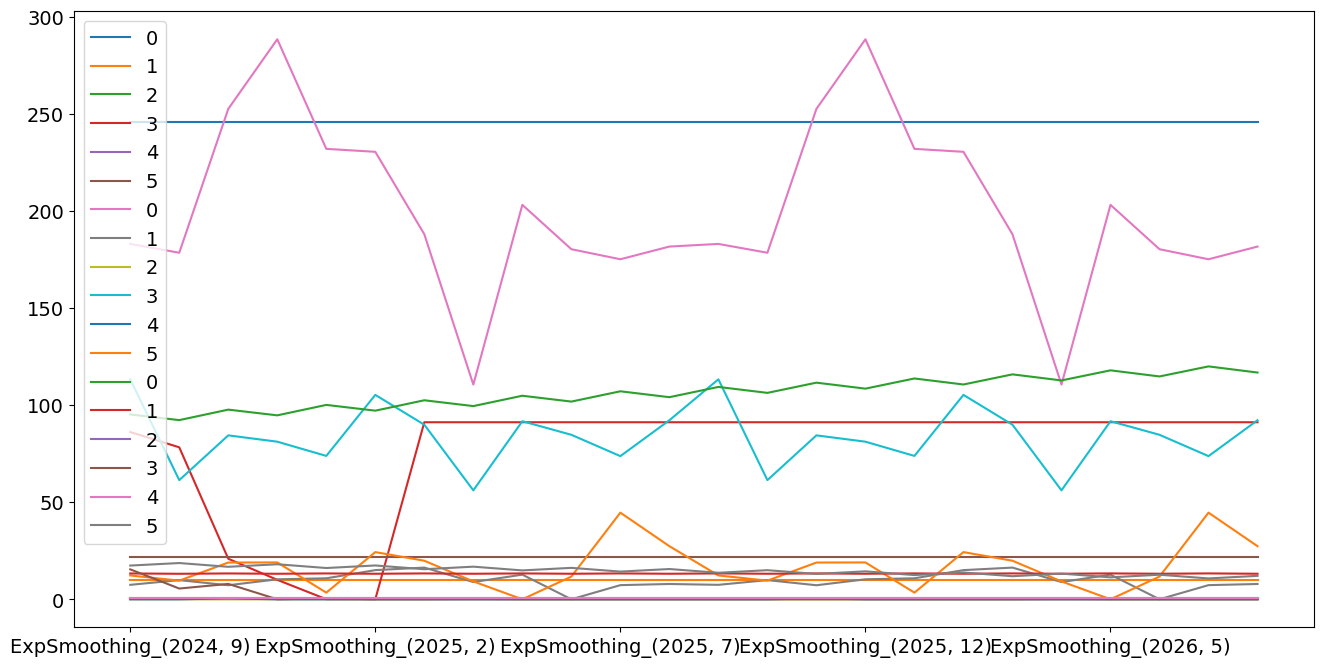

In [ ]:
if debug==True:
    ax=k.T.iloc[4:28,:].plot()
    ax2=k.T.iloc[28:(28+24),:].plot(ax=ax)
    ax3=k.T.iloc[(28+24):(28+2*24),:].plot(ax=ax2)
    k.T.iloc[(28+2*24):(28+3*24),:].plot(ax=ax3)

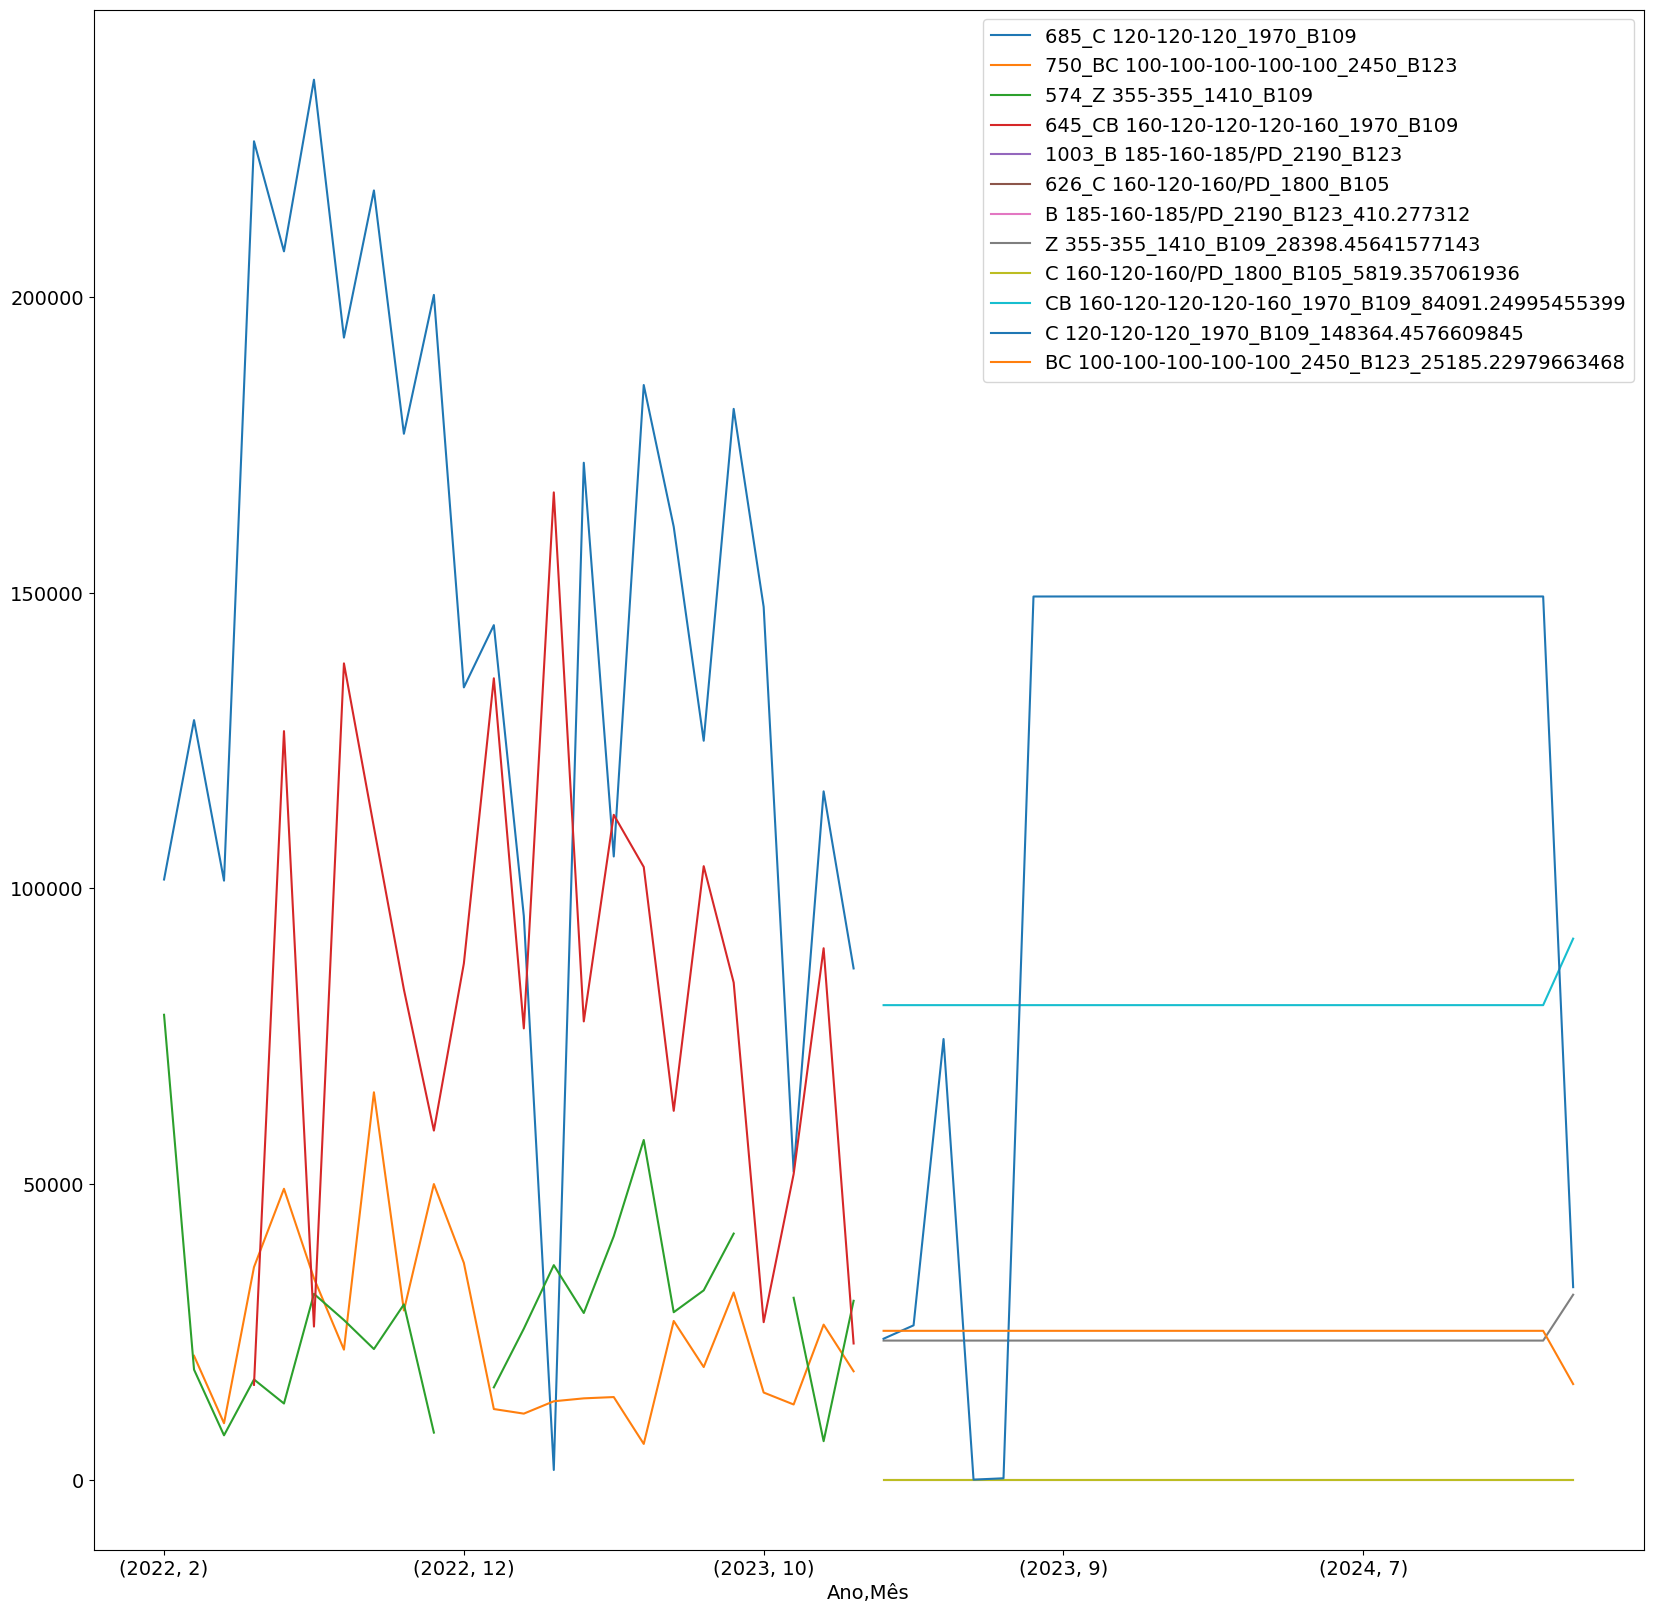

In [ ]:
if debug==True:
    pred_ = k.T.iloc[:29,:]
    pred_.columns = k.T.iloc[0:4,:].astype(str).apply('_'.join, axis=0)
    pred_=pred_.iloc[5:29,:]
    dates = pd.date_range(start='2023-03-01', end='2025-03-01', freq='M')
    index = pd.MultiIndex.from_tuples([(date.year, date.month) for date in dates], names=['Ano', 'Mês'])
    pred_.set_index(index, inplace=True)
    # ax=grupo[grupo.mean().sort_values().index].plot(figsize=(20,4))#plota as séries começando com a que tem a menor média
    # pred_.plot(figsize=(20,4),ax=ax)#plota as séries começando com a que tem a menor média
    pd.concat([grupo,pred_]).plot(figsize=(20,20))
    #k.T.iloc[:29,:]

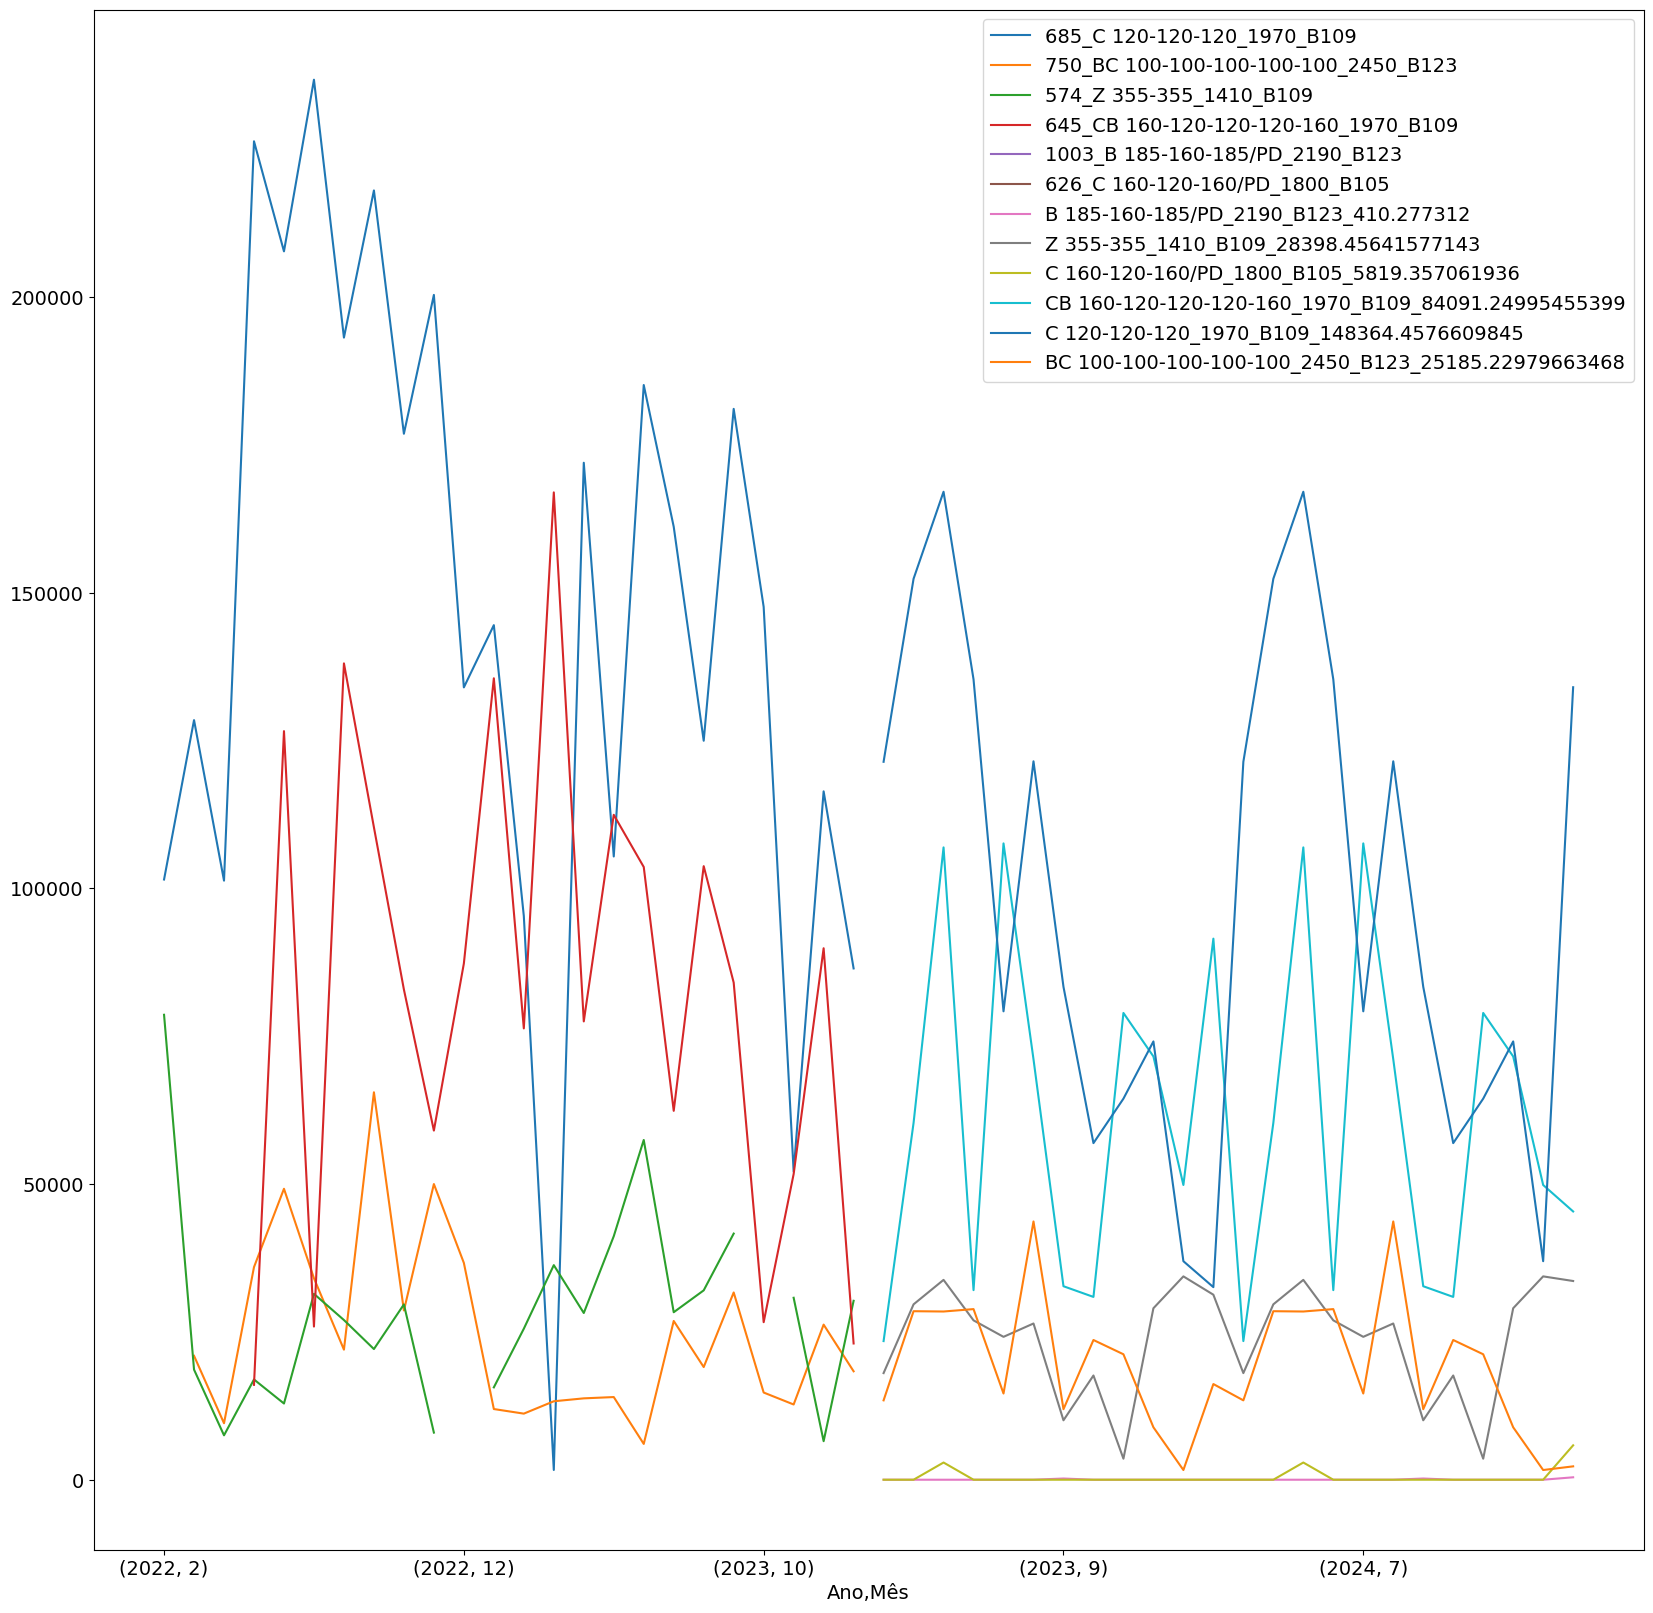

In [ ]:
if debug==True:
    pred_ = k.T.iloc[29:53,:]
    pred_.columns = k.T.iloc[0:4,:].astype(str).apply('_'.join, axis=0)
    dates = pd.date_range(start='2023-03-01', end='2025-03-01', freq='M')
    index = pd.MultiIndex.from_tuples([(date.year, date.month) for date in dates], names=['Ano', 'Mês'])
    pred_.set_index(index, inplace=True)
    # ax=grupo[grupo.mean().sort_values().index].plot(figsize=(20,4))#plota as séries começando com a que tem a menor média
    # pred_.plot(figsize=(20,4),ax=ax)#plota as séries começando com a que tem a menor média
    pd.concat([grupo,pred_]).plot(figsize=(20,20))
    #k.T.iloc[29:53,:]


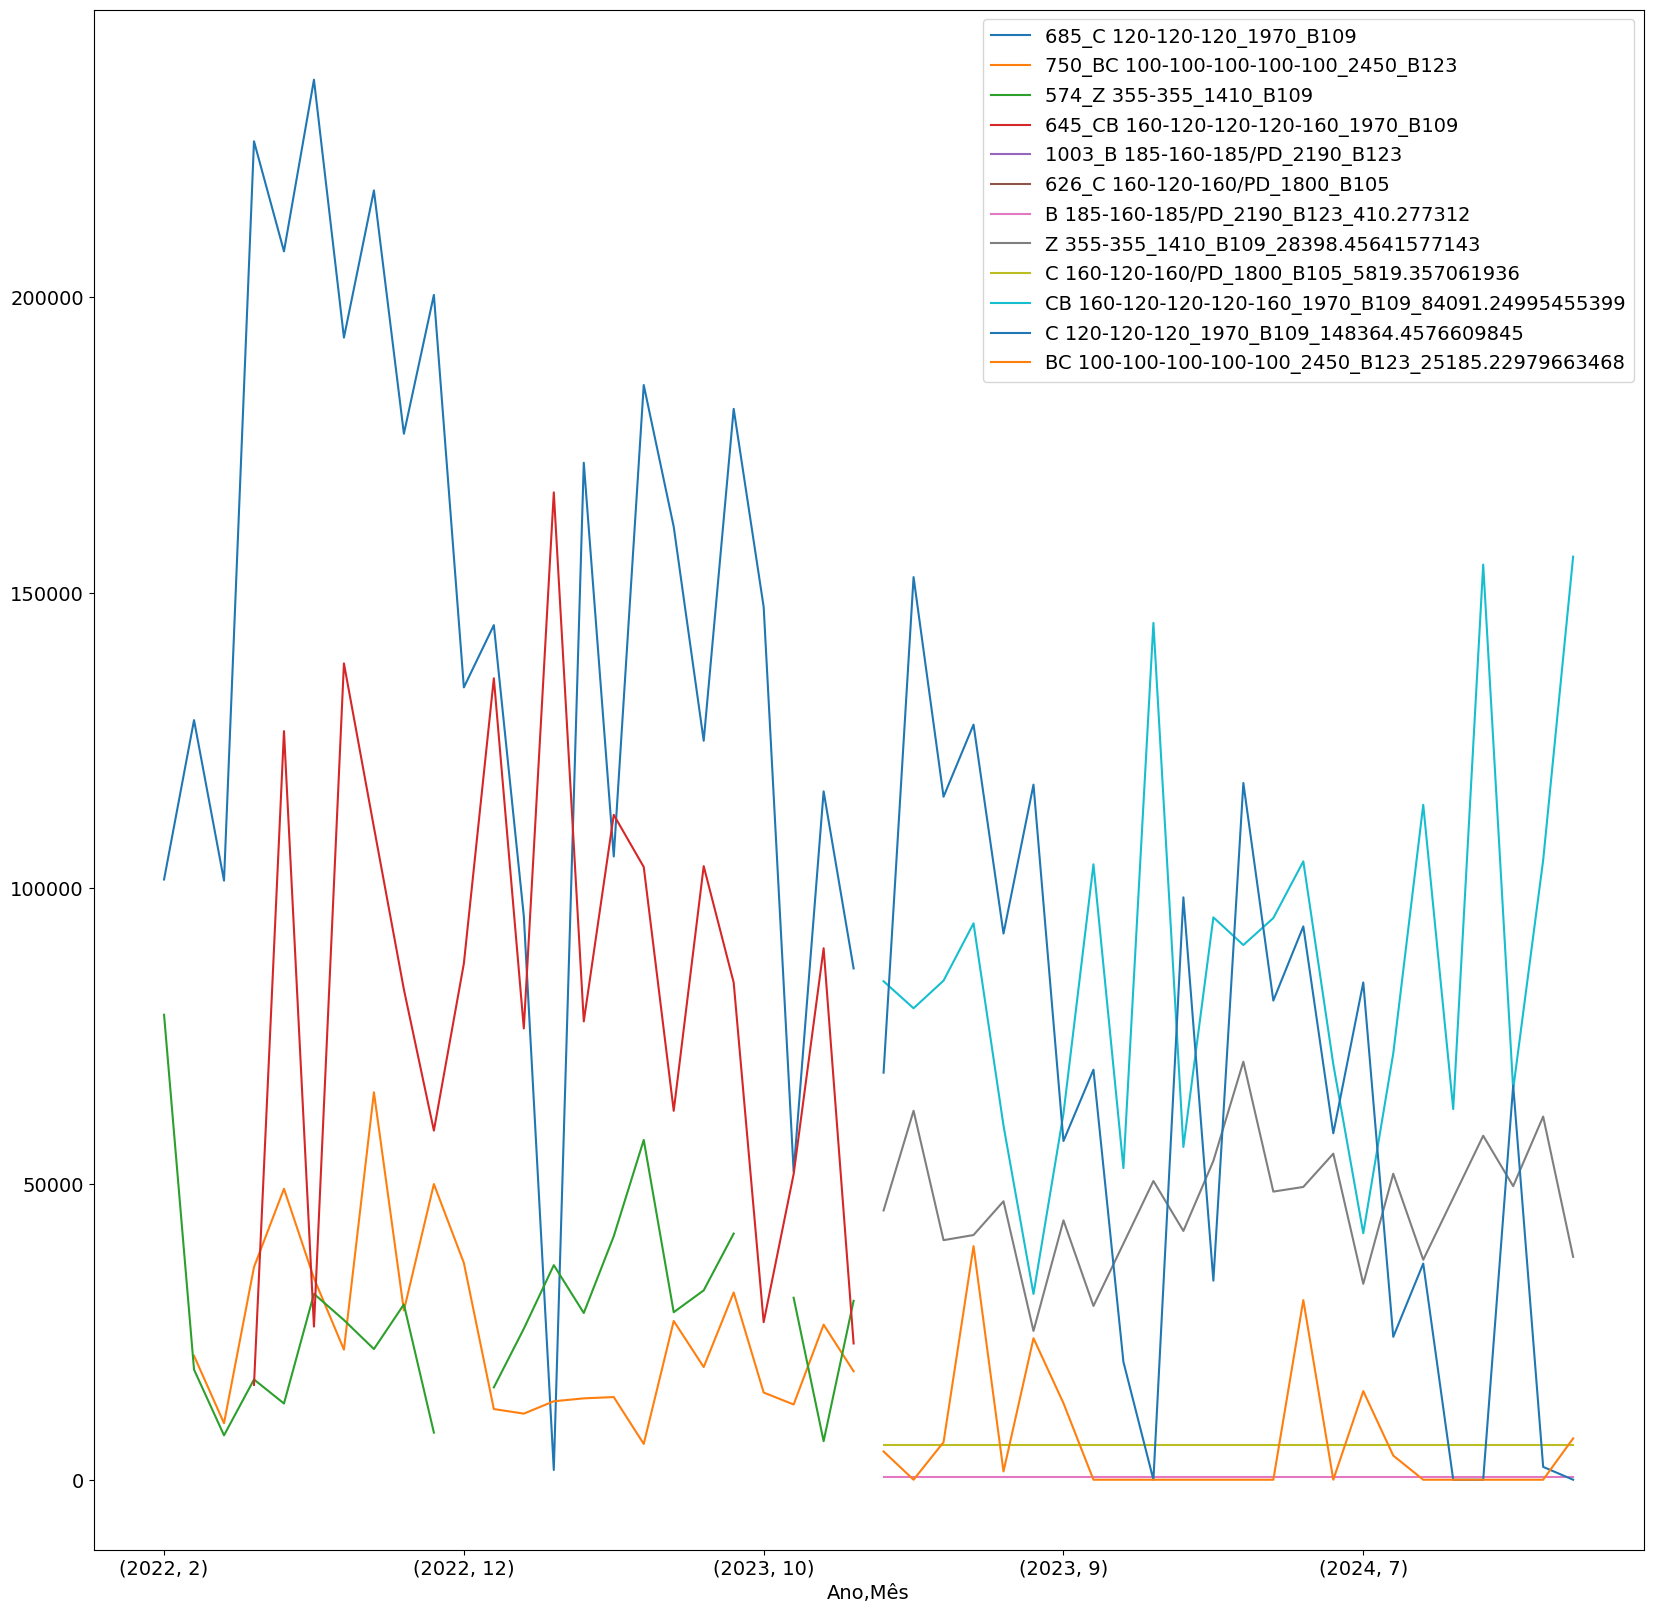

In [ ]:
if debug==True:
    pred_ = k.T.iloc[53:77,:]
    pred_.columns = k.T.iloc[0:4,:].astype(str).apply('_'.join, axis=0)
    dates = pd.date_range(start='2023-03-01', end='2025-03-01', freq='M')
    index = pd.MultiIndex.from_tuples([(date.year, date.month) for date in dates], names=['Ano', 'Mês'])
    pred_.set_index(index, inplace=True)
    # ax=grupo[grupo.mean().sort_values().index].plot(figsize=(20,4))#plota as séries começando com a que tem a menor média
    # pred_.plot(figsize=(20,4),ax=ax)#plota as séries começando com a que tem a menor média
    pd.concat([grupo,pred_]).plot(figsize=(20,20))
    #k.T.iloc[53:77,:]